In [95]:
import pandas as pd
import numpy as np
import scipy as sp
import math
import Hull_White as hw
import Discount_Functions as disc_func
import itertools
import matplotlib.pyplot as plt

%matplotlib inline

#### All data given as of 8/28/2004

In [53]:
cap_rate = 0.0475      # given in HW2_Data file
short_rate = 0.01816   # given in HW2_Data file
dt = 0.25

HW = hw.Hull_White()   #our Hull White class
K = 1/(1+cap_rate*dt)  #strike in put model

# from HW1 problem set
kappa = 0.153
sigma = 0.0153

# from HW1 REMIC data file
WACs = [0.05402, 0.05419]   # WAC values for two pools

In [54]:
df_stmat = pd.read_csv('stmat.csv')
df_tvmat = pd.read_csv('tvmat.csv')
df_disc_factors = pd.read_csv('discount factors.csv')
df_caplet_vols = pd.read_csv('caplet vols.csv')
df_mthly_10_yr_LIBOR_04 = pd.read_csv('monthly 10 year LIBOR spot rates for 2004.csv')

df_stmat['Coupon Gap'] = df_stmat['Coupon Gap'] * 0.0001 # convert from basis points to decimal
df_tvmat['Coupon Gap'] = df_tvmat['Coupon Gap'] * 0.0001 # convert from basis points to decimal

#### Forward rates from dicsount functions

In [55]:
## import and clean data
data_z = pd.read_csv("discount factors.csv", header = 0)

## fit Z curve using OLS
data_z["poly"] = np.log(data_z["Price"])
z_OLS = disc_func.OLS(disc_func.power_5(data_z["Maturity"]), data_z["poly"])
print("my estimation of coefficients are:")
print(z_OLS.beta)

(a,b,c,d,e) = z_OLS.beta
coeff = [a,b,c,d,e]

my estimation of coefficients are:
[ -2.32447481e-02  -3.81606103e-03   1.62964402e-04  -3.02679751e-06
   2.09422571e-08]


[0.053900000000000003, 0.052200000000000003, 0.050999999999999997, 0.045674035220837447, 0.046020573113347139, 0.046362208952240143, 0.046698982429263, 0.047030933048741258]
240


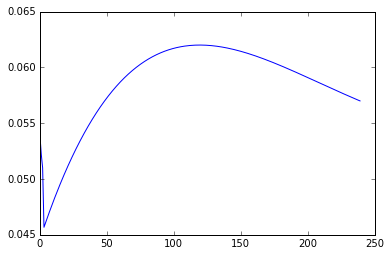

In [117]:
# Comment by Kunming: Ignore this for now
'''
t_range = np.arange(1,241-3)/12
r0 = short_rate
#r0 = df_mthly_10_yr_LIBOR_04['Rate'][8]
libor_rate_arr = [df_mthly_10_yr_LIBOR_04['Rate'][i] for i in range(5,8)]
Z_arr = []
r_arr = []

for t in t_range:
    Z_10 = HW.Z(0, t+10, r0, kappa, sigma, coeff)
    Z_1 = HW.Z(0, t, r0, kappa, sigma, coeff)
    
    r_10 = HW.r_t(0, t+10, r0, kappa, sigma, coeff)
    r_1 = HW.r_t(0, t, r0, kappa, sigma, coeff)
    r_arr.append(HW.r_t(0, t+10, r0, kappa, sigma, coeff))
   
    # r(t1, t2) = (1/(t2 - t1)) * ( ln(DF(0,t1)) - ln(DF(0,t2)) )
    #libor_rate_arr.append((np.log(Z_1) - np.log(Z_10)) / (t+10 - t))
    libor_rate_arr.append((r_10*(t+10) - r_1*(t)) / (t+10 - t))
    
#plt.plot(libor_rate_arr[3:])
#plt.plot(r_arr)
plt.plot(libor_rate_arr)
print(libor_rate_arr[:8])
print(len(libor_rate_arr))
'''


#### Ouput results from matlab functions

In [78]:
gamma = 0.0568
p = 2.9025
beta_1 = -12.6051
beta_2 = -2.0992

#### Standard error results from matlab code

In [79]:
gamma_se = 0.0018
p_se = 0.0750
beta_1_se = 1.9998
beta_2_se = 0.0495

# Q1

#### hazard function

In [127]:
beta = np.array([beta_1, beta_2])

def libor_rate_10yr_lag3(t):
    #here the time input t should be integer month
    if t==1:
        return 0.0539
    elif t==2:
        return 0.0522
    elif t==3:
        return 0.0510
    else:
        t = (t-3)/12
        r_10 = HW.r_t(0, t+10, r0, kappa, sigma, coeff)
        r_1 = HW.r_t(0, t, r0, kappa, sigma, coeff)
        return((r_10*(t+10) - r_1*(t)) / (t+10 - t))

def summer_index_func(t):
    # starting from Sept. plus 8
    t = t + 8
    return 1 if t%12 in [5,6,7,8] else 0

def hazard_func(t, gamma, p, beta, pool):
    #here the time input t should be integer month
    t = int(t)
    v = np.array([WACs[pool] - libor_rate_10yr_lag3(t), summer_index_func(t)])
    exp_val = np.dot(v, beta)
    return ((gamma*p * (gamma * t)**(p-1)) / (1 + (gamma * t)**p)) * np.exp(exp_val)

def SMM_func(tminus, tplus, gamma, p, beta, pool):
    int_res = sp.integrate.quad(lambda s: hazard_func(s, gamma, p, beta, pool), tminus, tplus)[0]
    return(1-np.exp(-int_res))


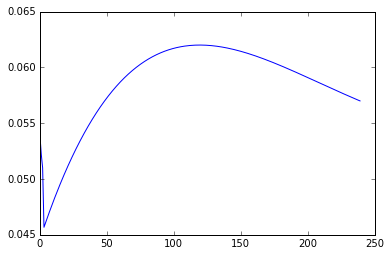

In [124]:
libor_rate_10yr_lag3_arr = []
t_range = np.arange(1,241)
for t in t_range:
    libor_rate_10yr_lag3_arr.append(libor_rate_10yr_lag3(t))
plt.plot(libor_rate_10yr_lag3_arr)

In [129]:
hazard_arr_1 = []
hazard_arr_2 = []
SMM_arr_1 = []
SMM_arr_2 = []

for t in range(240):
    hazard_arr_1.append(hazard_func(t, gamma, p, beta, 0))
    hazard_arr_2.append(hazard_func(t, gamma, p, beta, 1))
    SMM_arr_1.append(SMM_func(t, t+1, gamma, p, beta, 0))
    SMM_arr_2.append(SMM_func(t, t+1, gamma, p, beta, 1))

240


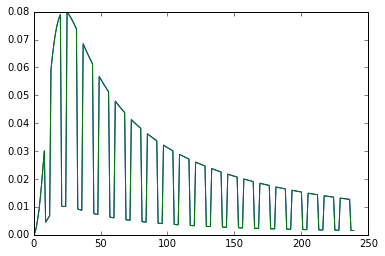

In [130]:
plt.plot(SMM_arr_1)
plt.plot(SMM_arr_2)
print(len(SMM_arr_1))

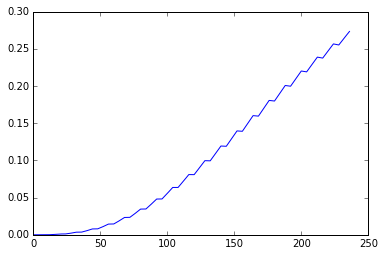

In [46]:
ave_hazard_arr_1 = np.cumsum(hazard_arr_1) / (t_range + 10)
ave_hazard_arr_2 = np.cumsum(hazard_arr_2) / (t_range + 10)
plt.plot(ave_hazard_arr_1)

# Qc

### Effective Duration

In [11]:
HW